In [17]:
from datasets import Dataset
import madmom
import numpy as np
from madmom.audio.filters import MelFilterbank
import matplotlib.pyplot as plt
from modules.vis import onset_visualizer, passage_extractor, slur_visualizer
import tensorflow as tf
from modules.analysis_funcs import get_segmented_data, get_test_peaks

In [2]:
ds0 = Dataset("initslurtest")
audio_fnames = ds0.get_audio_paths()
sample_rates = [madmom.audio.signal.load_wave_file(filename)[1] for filename in audio_fnames]
audios = [madmom.audio.signal.load_wave_file(filename)[0] for filename in audio_fnames]
SR = 44100

/usr/local/lib/python3.9/site-packages/madmom/audio/signal.py:457: UserWarning: Deprecated as of version 0.16. Please use madmom.io.audio.load_wave_file instead. Will be removed in version 0.18.
  warnings.warn('Deprecated as of version 0.16. Please use madmom.io.audio.'
/usr/local/lib/python3.9/site-packages/madmom/io/audio.py:493: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


In [9]:
R=9
bock = madmom.features.onsets.CNNOnsetProcessor()
pp = madmom.features.onsets.OnsetPeakPickingProcessor(threshold=0.7, combine=0.1)

In [13]:
sb_onsets = pp(bock(audios[R]))
note_onsets = np.loadtxt("datasets/initslurtest_vn/note_onsets/slurtest10_first.txt", usecols=0)

In [18]:
# CNN method
base_path = "results/cnn-training-220426/"
model_name = "ab-seq-90eps-nostandard-trainable-noextend-dropout0.3"
model = tf.keras.models.load_model(base_path + 'fold_{}_{}_model'.format(0, model_name))

cnn_input = get_segmented_data(audio_fnames[R])
cnn_output = model.predict(cnn_input)
cnn_onsets = get_test_peaks(cnn_output, 1./100)

2022-05-25 14:50:52.727616: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


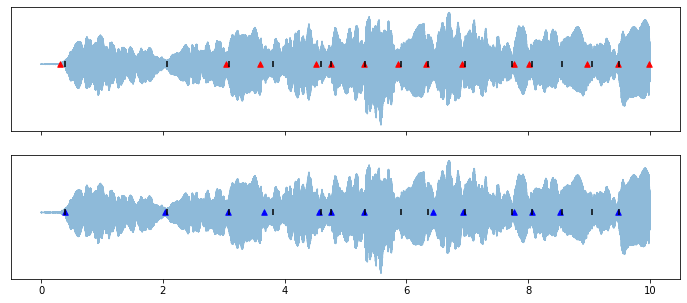

In [21]:
passages = [passage_extractor(
    audios[R], 
    onset_set,
    [0.0,10.0], 
    sr=sample_rates[R]
)[0] for onset_set in [
    [
        note_onsets,
        sb_onsets
    ],
    [
        note_onsets,
        cnn_onsets
    ],
]
]

fig,axs = plt.subplots(len(passages),1, figsize=(12,2.5*len(passages)), sharex=True)
onset_styles = [
    {"m":["|","^"], "c":["k", "r"]},
    {"m":["|","^"], "c":["k", "b"]}
]

for plot_i, (passage, ax, onset_style) in enumerate(zip(passages, axs, onset_styles)):
    ax.set_yticks([])
    onset_visualizer(
        passage["audio"], 
        passage["onsets"], 
        (passage["abs_start"], passage["abs_end"]),
        onset_styles=onset_style,
        ax=ax,
        alpha=0.5
        )

In [4]:
frames = madmom.audio.signal.FramedSignal(
    audios[0], 
    frame_size=2048, 
    hop_size=440,
)
stft = madmom.audio.stft.ShortTimeFourierTransform(
    frames
)


(1000,)

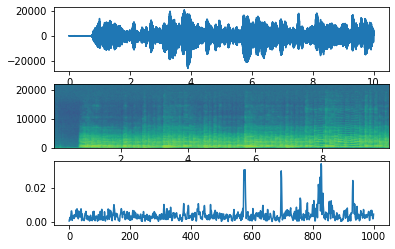

In [32]:
fig, axs = plt.subplots(3,1)
axs[0].plot(np.linspace(0,10,44100*10), audios[0][0:44100*10])
axs[1].specgram(audios[0][0:44100*10], Fs=44100, NFFT=1024, window=np.hanning(1024), mode="magnitude", noverlap=512)
axs[2].plot(np.abs(stft)[:10*100,900])

In [39]:
freq = madmom.audio.stft.fft_frequencies(stft.shape[1], 44100)
mel = MelFilterbank(freq, 80, 17.5, 16000, True)
mel.shape

(1024, 80)

In [35]:
phase = madmom.audio.stft.phase(stft)
lgd = madmom.audio.stft.lgd(phase)
lgd.shape

(1701, 1024)

In [44]:
filtered_lgd = np.zeros((lgd.shape[0], 80))
for f in range(1024):
    mel[f]

(array([5]), array([2]))

In [20]:
filtered_lgd = madmom.audio.spectrogram.FilteredSpectrogram(
    spectrogram=lgd,
    filterbank=MelFilterbank,
    num_bands=80,
    fmin=27.5,
    fmax=16000,
    norm_filters=True,
    unique_filters=False
)

ValueError: frames must be a 2D array or iterable, got <class 'madmom.audio.signal.FramedSignal'> with shape (4, 2048, 1024).

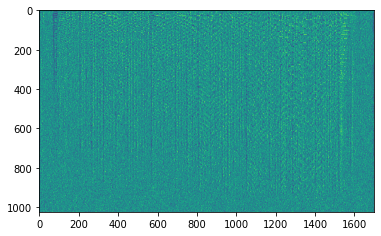

In [10]:
import matplotlib.pyplot as plt
plt.imshow(lgd.transpose())

In [12]:
print(stft.shape)
print(lgd.shape)

(1701, 1024)
(1701, 1024)
